<a href="https://colab.research.google.com/github/fjadidi2001/AD_Prediction/blob/main/Denoise_May18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set Up Environment



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Installed Packages:
         Package       Version
0          torch   2.6.0+cu124
1    torchvision  0.21.0+cu124
2  opencv-python     4.11.0.86
3           h5py        3.13.0
4   scikit-image        0.25.2


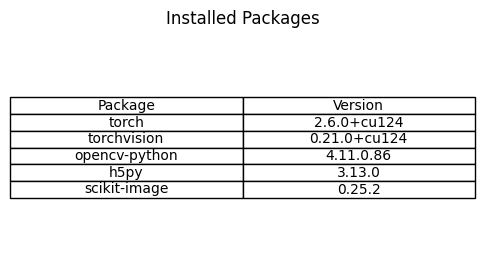

In [14]:
# Cell 1: Set Up Environment
from google.colab import drive
import os
import pkg_resources
import pandas as pd
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

# Install dependencies
!pip install torch torchvision opencv-python h5py scikit-image --quiet

# Create directories
base_dir = '/content/drive/MyDrive/SSNet'
os.makedirs(base_dir, exist_ok=True)
os.makedirs(f'{base_dir}/data', exist_ok=True)
os.makedirs(f'{base_dir}/data/Kodak24', exist_ok=True)
os.makedirs(f'{base_dir}/logos', exist_ok=True)
os.makedirs(f'{base_dir}/saved_models', exist_ok=True)
os.makedirs(f'{base_dir}/ckpts', exist_ok=True)
os.makedirs(f'{base_dir}/output', exist_ok=True)

# Collect installed package versions
packages = ['torch', 'torchvision', 'opencv-python', 'h5py', 'scikit-image']
installed = {pkg: pkg_resources.get_distribution(pkg).version for pkg in packages}

# Create table
df = pd.DataFrame(list(installed.items()), columns=['Package', 'Version'])
print("Installed Packages:")
print(df)

# Plot table
plt.figure(figsize=(6, 3))
plt.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center')
plt.axis('off')
plt.title("Installed Packages")
plt.savefig(f'{base_dir}/output/installed_packages.png')
plt.show()

--2025-05-18 06:52:15--  https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz
Resolving www2.eecs.berkeley.edu (www2.eecs.berkeley.edu)... 128.32.244.190
Connecting to www2.eecs.berkeley.edu (www2.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70763455 (67M) [application/x-tar]
Saving to: ‘BSR_bsds500.tgz’

BSR_bsds500.tgz     100%[===================>]  67.48M  47.8MB/s    in 1.4s    

2025-05-18 06:52:17 (47.8 MB/s) - ‘BSR_bsds500.tgz’ saved [70763455/70763455]

Dataset loaded successfully
Processing BSR dataset...
Dataset Statistics:
       Subset  Images  Patches  HDF5 Size (MB)
0       Train     200     1200      900.431168
1  Validation     100      100      176.735031
2        Test     200      200      353.470795


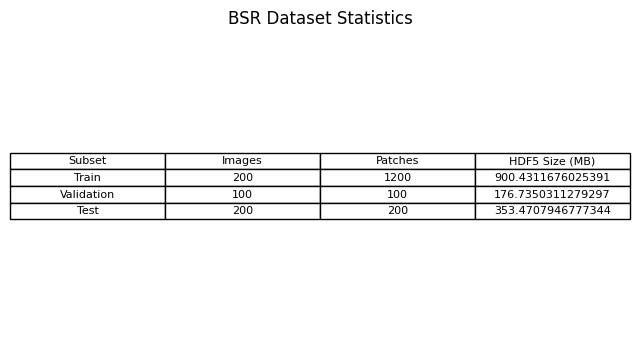

In [15]:
# Cell 2: Download and Preprocess BSR Dataset
import os
import glob
import cv2
import numpy as np
import h5py
import random
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

# Download and extract BSR dataset
try:
    if not os.path.exists('BSR_bsds500.tgz'):
        !wget https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz
    if not os.path.exists('BSR'):
        !tar xzf BSR_bsds500.tgz
    print("Dataset loaded successfully")
except Exception as e:
    print(f"Error loading dataset: {e}")

# Define data preparation function
def normalize(data):
    return data / 255.

def Im2Patch(img, win, stride=1):
    k = 0
    endc = img.shape[0]
    endw = img.shape[1]
    endh = img.shape[2]
    patch = img[:, 0:endw-win+0+1:stride, 0:endh-win+0+1:stride]
    TotalPatNum = patch.shape[1] * patch.shape[2]
    Y = np.zeros([endc, win*win, TotalPatNum], np.float32)
    for i in range(win):
        for j in range(win):
            patch = img[:, i:endw-win+i+1:stride, j:endh-win+j+1:stride]
            Y[:, k, :] = np.array(patch[:]).reshape(endc, TotalPatNum)
            k = k + 1
    return Y.reshape([endc, win, win, TotalPatNum])

def prepare_data(data_path, bsr_root, patch_size=256, stride=128, aug_times=1, mode='color'):
    print('Processing BSR dataset...')
    scales = [1, 0.9, 0.8, 0.7]

    # Collect train, val, test images
    train_files = glob.glob(os.path.join(bsr_root, 'BSR/BSDS500/data/images/train', '*.jpg'))
    val_files = glob.glob(os.path.join(bsr_root, 'BSR/BSDS500/data/images/val', '*.jpg'))
    test_files = glob.glob(os.path.join(bsr_root, 'BSR/BSDS500/data/images/test', '*.jpg'))

    # Process training data
    h5f = h5py.File(os.path.join(data_path, 'train_color_right.h5'), 'w')
    train_num = 0
    for i in range(len(train_files)):
        img = cv2.imread(train_files[i])
        h, w, c = img.shape
        for k in range(len(scales)):
            if int(h * scales[k]) < 256 or int(w * scales[k]) < 256:
                continue
            Img = cv2.resize(img, (int(w * scales[k]), int(h * scales[k])), interpolation=cv2.INTER_CUBIC)
            Img = np.transpose(Img, (2, 0, 1))
            Img = np.float32(normalize(Img))
            patches = Im2Patch(Img, win=patch_size, stride=stride)
            for n in range(patches.shape[3]):
                data = patches[:, :, :, n].copy()
                h5f.create_dataset(str(train_num), data=data)
                train_num += 1
                for m in range(aug_times - 1):
                    data_aug = data_augmentation(data, np.random.randint(1, 8))
                    h5f.create_dataset(str(train_num) + "_aug_%d" % (m + 1), data=data_aug)
                    train_num += 1
    h5f.close()

    # Process validation data
    h5f = h5py.File(os.path.join(data_path, 'val_color_right.h5'), 'w')
    val_num = 0
    for i in range(len(val_files)):
        img = cv2.imread(val_files[i])
        img = np.transpose(img, (2, 0, 1))
        img = np.float32(normalize(img))
        h5f.create_dataset(str(val_num), data=img)
        val_num += 1
    h5f.close()

    # Process test data (optional, for testing)
    h5f = h5py.File(os.path.join(data_path, 'test_color_right.h5'), 'w')
    test_num = 0
    for i in range(len(test_files)):
        img = cv2.imread(test_files[i])
        img = np.transpose(img, (2, 0, 1))
        img = np.float32(normalize(img))
        h5f.create_dataset(str(test_num), data=img)
        test_num += 1
    h5f.close()

    # Collect statistics
    stats = {
        'Subset': ['Train', 'Validation', 'Test'],
        'Images': [len(train_files), len(val_files), len(test_files)],
        'Patches': [train_num, val_num, test_num],
        'HDF5 Size (MB)': [
            os.path.getsize(f'{data_path}/train_color_right.h5') / 1024**2,
            os.path.getsize(f'{data_path}/val_color_right.h5') / 1024**2,
            os.path.getsize(f'{data_path}/test_color_right.h5') / 1024**2
        ]
    }
    df = pd.DataFrame(stats)
    print("Dataset Statistics:")
    print(df)

    # Plot table
    plt.figure(figsize=(8, 4))
    plt.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center')
    plt.axis('off')
    plt.title("BSR Dataset Statistics")
    plt.savefig(f'{base_dir}/output/dataset_stats.png')
    plt.show()

# Run preparation
prepare_data(f'{base_dir}/data', '.', patch_size=256, stride=128, aug_times=1, mode='color')